In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings
# !pip install pandas_datareader
# !pip install yfinance
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")


pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [12]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2024, 1, 1)

tickers = ['ADBE','MSFT']


df = yf.download(tickers, start, end)['Close']
df.tail()

S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

[*********************100%***********************]  2 of 2 completed


0.7025432990908552

In [13]:
ratios = df['ADBE'] / df['MSFT']
# print(len(ratios) * .70 )
train = ratios[:881]
test = ratios[881:]

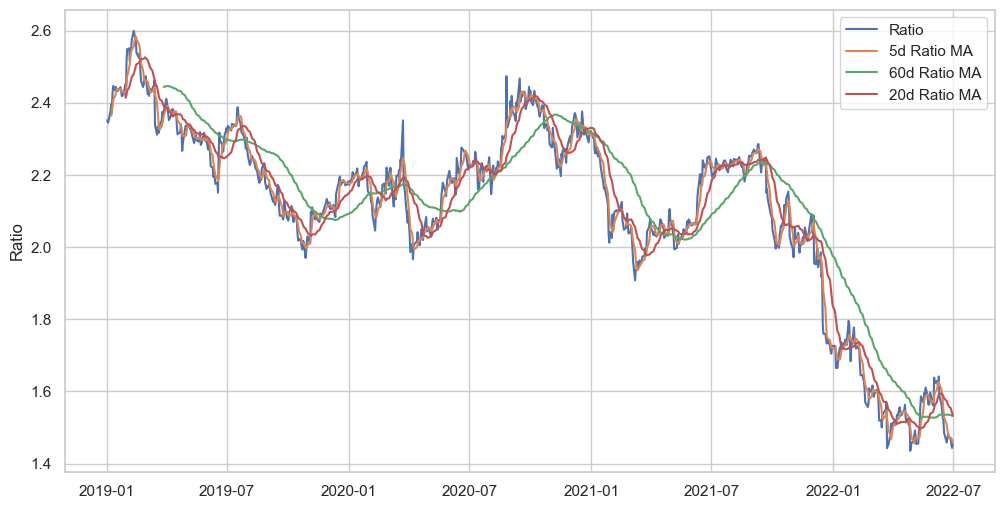

In [14]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
ratios_mavg20 = train.rolling(window=20, center = False).mean()

std_60 = train.rolling(window=60, center=False).std()
ratios_roc = ((ratios - ratios.shift(10))/ratios.shift(10))*100

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA', '20d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

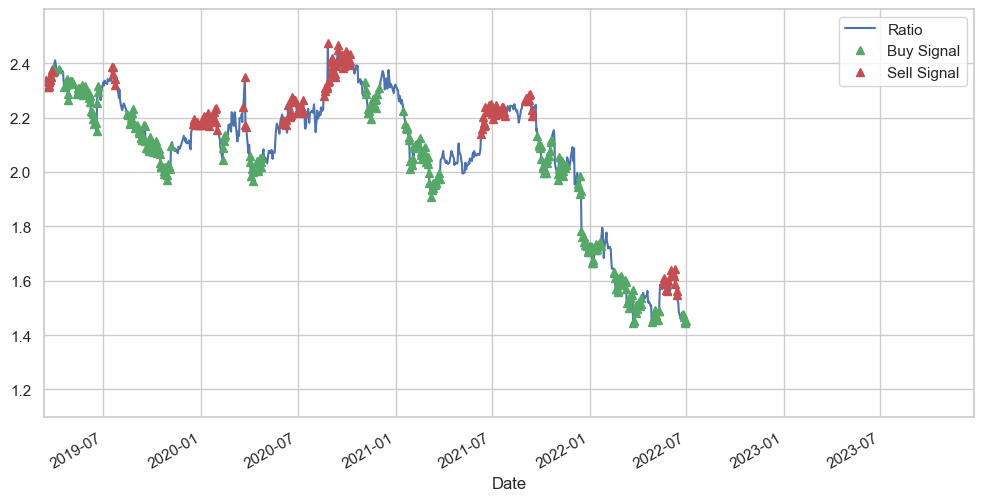

In [15]:
plt.figure(figsize=(12,6))

train[50:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[50:].plot(color='g', linestyle='None', marker='^')
sell[50:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2019-03-12','2023-12-25')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

In [17]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [18]:
trade(df['ADBE'].iloc[881:], df['MSFT'].iloc[881:], 60, 5)

448.09437320120685